# Learning Auctions Introduction

In this tutorial, we design, or more aptly learn, auction mechanisms that are approximately revenue optimal while satisfying certain constraints concerning bidder incentives.  The mechanisms themselves will be composed of two networks: an allocation-rule network and a payment-rule network.  This notebook serves as an introduction to the problem domain and focuses on settings were a set of bidders are competing to win a single item via an auction.

## Theoretical framework 
We adopt the framework of [Dutting et al. (2018)](https://arxiv.org/pdf/1706.03459.pdf)

* there are $n$ bidders ($N$) over $m$ items ($M$);
* each bidder $i\in N$ has some value function $v_i: 2^M \rightarrow \mathbb{R}_+$ drawn indepdendently from some distribution $F_i$ over value functions $V_i$;
* the profile of valuations is denoted by $v=(v_1, \ldots, v_n)$;
* the auctioneer knows $F=(F_1, \ldots, F_n)$ but does not know $v$;
* the auctioneer runs a mechanism ($\mathcal{M}=(g,p)$) with allocation rules $g_i: V \rightarrow 2^M$ and payment rules $p_i : V\rightarrow \mathbb{R}_{\ge 0};$
* the auction collects bids $b = (b_1, \ldots , b_n) \in V$, and then computes an allocation $g(b)$ and payments $p(b)$.

We search to design, or more aptly learn, a dominant-strategy incentive-compatible ([DSIC](https://en.wikipedia.org/wiki/Incentive_compatibility)) and individually rational ([IR](https://en.wikipedia.org/wiki/Rational_choice_theory)) mechanism that maximizes expected revenue:

$$
\max_{g,p} E_{v\sim F} \left[\sum_i p(v)\right]\ \ \text{s.t.}\ \ (g,p)\in \text{DISC},\ \ (g,p)\in \text{IR}
$$

The authors encode the DISC and IR constraints as follows:

* DISC: $u_i(v_i, (v_i, b_{−i})) \ge u_i(v_i, (b_i, b_{−i}))$;
* IR: $u_i(v_i,(v_i,b_{−i})) \ge 0$.

## Architectures and supporting functions

### Preliminaries

We will make heavy use of numpy, pandas, and pytorch.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

We will also make use of matplotlib and seaborn for visualization:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Common components

All mechanism networks will output allocations and payments.  The allocation shape is `[batch_size, bidders+1]`.  The first column represents the probability that the item is not allocated, with all other columns representing the probability that the item is allocated to the respective bidder.  The payment shape is `[batch_size, bidders]`.  Here each column represents the payment of the respective bidder.

We define a generic mechanism as follows:

In [3]:
class MechanismNet(nn.Module):
    def __init__(self, allocation_rule, payment_rule):
        super(MechanismNet, self).__init__()
        self.allocation_rule = allocation_rule
        self.payment_rule = payment_rule
        
    def forward(self, x):
        allocation = self.allocation_rule(x)
        return allocation, allocation[:,1:] * self.payment_rule(x)

Utility can thusly be calculated by:

In [4]:
def calc_utility(bids, mechanism, valuation=None, output_components=False):
    valuation = valuation if valuation is not None else bids
    allocation, payment = mechanism(bids)
    if output_components:
        return allocation[:,1:]*valuation-payment, allocation, payment
    else:
        return allocation[:,1:]*valuation-payment

The `calc_utility` function will return a tensor of shape `[batch_size,bidders]`.

In order to determine if a mechanism is (approximately) DISC, we calculate regret:

In [5]:
# Code inspired by https://github.com/saisrivatsan/deep-opt-auctions/blob/master/regretNet/trainer/trainer.py

def calc_regret(values, mechanism, misreport_samples=100, region_size=1):
    # Extract the basic shapes
    batch_size, bidders = values.shape
    
    # We will generate tensors of the following size
    intermediate_shape = [bidders, misreport_samples, batch_size, bidders]
    
    # Generate multipliers in the range [-1,1)
    unit_multipliers = 2.0*torch.rand(intermediate_shape[1:])-1.0
    # Enforce that all multipliers are in [max {0, 1-region_size}, 1+region_size]
    misreport_multipliers = F.relu(1.0+unit_multipliers*region_size)
    
    # Use the unilateral_mask to only allow unilateral changes to valuations
    unilateral_mask = torch.zeros(intermediate_shape)
    unilateral_mask[np.arange(bidders), :, :, np.arange(bidders)] = 1.0
    
    # Repeat to get a tensor of shape [bidders, misreport_samples, batch_size, bidders]
    misreport_multipliers = misreport_multipliers.unsqueeze(0).repeat([bidders, 1, 1, 1])
    
    # Send to device, if necessary
    if device:
        unilateral_mask = unilateral_mask.to(device)
        misreport_multipliers = misreport_multipliers.to(device)
    
    # Extend the values to be of shape [bidders, misreport_samples, batch_size, bidders] 
    values_reshaped = values.repeat([bidders * misreport_samples, 1]).reshape(intermediate_shape)
    
    # Take the original values and generate 
    # a misreported value using the multipliers.
    misreported_values = values_reshaped * misreport_multipliers
    
    # Enforce unilateral misreports using the bidder_bask
    unilaterally_misreported_values = values_reshaped*(1.0-unilateral_mask)+misreported_values*unilateral_mask
    
    # Intermediate shape is [batch_size * misreport_samples * bidders, bidders]
    # The utility calculation expects data in the shape of [-1, bidders]
    exploded_misreported = unilaterally_misreported_values.reshape([-1, bidders])
    exploded_values = values_reshaped.reshape([-1, bidders])
    
    # Calculate utilities
    utility_true = calc_utility(exploded_values, mechanism)
    utility_misreported = calc_utility(exploded_misreported, mechanism, exploded_values)
    
    # Misreport gain computation
    excess_from_utility = F.relu(utility_misreported - utility_true).reshape(intermediate_shape)*unilateral_mask
                                 
    # First, calculate the maximum gain from deviation for each bidder.  This is along dim=1.
    # Now the shape is [bidders, batch_size, bidders].
    # Again, calculate the maximum gain for each bidder.  This is along new dim=2.
    # Now the shape is [bidders, batch_size].
    # Take the mean across batches.
    # The final size should be [bidders].
    # Each entry represents the expected regret, per bidder, given the batch sample.
    return excess_from_utility.max(dim=1)[0].max(dim=2)[0].mean(dim=1)


Finally, we can define the training function.

In [6]:
import torch.optim as optim
import torch.utils.data as data_utils

def train(mechanism, values_loader, epochs=1, misreport_samples=100, region_size=1, rho=1, clipping_norm=None):
    # Initialize augmented lagrangian parameters
    lambda_dsic = torch.zeros(bidders).to(device)
    lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-3)

    report_data = []

    for epoch in range(epochs):
        for batch_idx,(values_list) in enumerate(values_loader):
            values = values_list[0].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                values, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = calc_regret(
                values, 
                mechanism,
                misreport_samples=misreport_samples,
                region_size=region_size)
    
            # compute individual rationality violation
            ir_violation = F.relu(-utility).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue\
                +(lambda_dsic*dsic_violation).sum()\
                +(lambda_ir*ir_violation).sum()\
                +0.5*rho*(total_dsic_violation.pow(2)+total_ir_violation.pow(2))
    
            # Trigger the autogradient calculation
            loss.backward()
            
            if clipping_norm:
                torch.nn.utils.clip_grad_norm_(mechanism.parameters(), clipping_norm)
        
            # Take a step towards the gradient
            mechanism_optimizer.step()
    
            with torch.no_grad():
                mechanism.eval()
                # Update the augmented lagrangian parameters
                dsic_violation_next = calc_regret(
                    values,
                    mechanism,
                    misreport_samples=misreport_samples,
                    region_size=region_size)
                u_next = calc_utility(values, mechanism)
                ir_violation_next = F.relu(-u_next).mean(dim=0)
                lambda_dsic = lambda_dsic + rho * dsic_violation_next
                lambda_ir = lambda_ir + rho * ir_violation_next
                mechanism.train()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item(),
                'loss':loss.item()})
            
    return pd.DataFrame(report_data)     

## RegretNet

[Dutting et al. (2018)](https://arxiv.org/pdf/1706.03459.pdf) proposed a network of the following form.  We give a pytorch implementation of the network.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

The allocation network is defined as follows:

In [8]:
class RegretNetAllocation(nn.Module):
    def __init__(self, bidders, hidden_layers, hidden_units):
        super(RegretNetAllocation, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders+1))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x):
        for layer in self.fc_layers[:-1]:
            x = torch.sigmoid(layer(x))
        return F.softmax(self.fc_layers[-1](x), dim=1)

The payment network is defined as follows:

In [9]:
class RegretNetPayment(nn.Module):
    def __init__(self, bidders, hidden_layers, hidden_units, output_act_fn):
        super(RegretNetPayment, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders))
        self.fc_layers = nn.ModuleList(fc_layers)
        self.output_act_fn = output_act_fn
        
    def forward(self, x):
        for layer in self.fc_layers[:-1]:
            x = torch.sigmoid(layer(x))
        return self.output_act_fn(self.fc_layers[-1](x))

Finally, we can define the RegretNet mechanism.  Note that the output activation function used by Dutting et al. was the `relu`.  In the examples, below we try both `relu` and `leaky_relu`.

In [10]:
def create_regret_net(bidders, hidden_layers=2, hidden_units=100, output_act_fn=F.relu):
    return MechanismNet(
        RegretNetAllocation(bidders, hidden_layers, hidden_units),
        RegretNetPayment(bidders, hidden_layers, hidden_units, output_act_fn))

## ShadeNet

ShadeNet is a modification to RegretNet that uses a network to compute the bid _shading_ factor to compute payments.  That is, the payment is equal to the product of the bid a factor in [0,1].

The allocation network is defined as follows:

In [29]:
class ShadeNetAllocation(nn.Module):
    def __init__(self, agents, hidden_units, recurrent_calls=5, act_fn=F.leaky_relu):
        super(ShadeNetAllocation, self).__init__()
        assert recurrent_calls > 1
        self.act_fn = act_fn
        self.recurrent_calls = recurrent_calls
        self.initial_layer = nn.Linear(agents, hidden_units)
        self.recurrent = nn.LSTM(hidden_units, hidden_units)
        self.last_layer = nn.Linear(hidden_units, agents+1)
        
    def forward(self, x):
        x = self.act_fn(self.initial_layer(x)).unsqueeze(0)
        _, hidden = self.recurrent(x)
        for _ in range(self.recurrent_calls-2):
            _, hidden = self.recurrent(x, hidden)
        output, hidden = self.recurrent(x, hidden)    
        return F.softmax(self.last_layer(output.squeeze(0)), dim=1)

The payment network is defined as follows:

In [32]:
class ShadeNetShader(nn.Module):
    def __init__(self, agents, hidden_units, recurrent_calls=5, act_fn=F.leaky_relu):
        super(ShadeNetShader, self).__init__()
        assert recurrent_calls > 1
        self.act_fn = act_fn
        self.recurrent_calls = recurrent_calls
        self.initial_layer = nn.Linear(agents, hidden_units)
        self.recurrent = nn.LSTM(hidden_units, hidden_units)
        self.last_layer = nn.Linear(hidden_units, agents)
        
    def forward(self, x):
        x = self.act_fn(self.initial_layer(x)).unsqueeze(0)
        _, hidden = self.recurrent(x)
        for _ in range(self.recurrent_calls-2):
            _, hidden = self.recurrent(x, hidden)
        output, hidden = self.recurrent(x, hidden) 
        return torch.sigmoid(self.last_layer(output.squeeze(0)))
    
class ShadeNetPayment(nn.Module):
    def __init__(self, shader):
        super(ShadeNetPayment, self).__init__()
        self.shader = shader
        
    def forward(self, x):
        return self.shader(x) * x

Finally, we can define the ShadeNet mechanism:

In [34]:
def create_shade_net(bidders, hidden_units=100, recurrent_calls=5, act_fn=F.leaky_relu):
    return MechanismNet(
        ShadeNetAllocation(bidders, hidden_units, recurrent_calls=recurrent_calls, act_fn=act_fn),
        ShadeNetPayment(ShadeNetShader(bidders, hidden_units, recurrent_calls=recurrent_calls, act_fn=act_fn)))

## Single-Item Auction

In the samples below, we evaluate RegetNet and ShadeNet on standard auction scenarios.  In each case, bidders valuations are drawn independently from $U[0,1]$.

### Single Bidder

For our warmup exercise, we consider only a single bidder.  From Myerson (81), we know that the optimal mechanism is a fixed price of 0.5.  Since the bidders values are drawn from uniformly from [0,1], we know that half of the draws will result in the bidder passing on the item, with the other half accepting at a price of 0.5.  Therefore, the optimal expected revenue is 0.25.

In [35]:
bidders = 1

The networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [36]:
sample_size = 1000
batch_size = 64

values_loader=data_utils.DataLoader(
    data_utils.TensorDataset(torch.rand(sample_size, bidders)),
    batch_size=batch_size)

We consider three different networks: RegretNet, RegretNet with a `leaky_relu` output activation function, and ShadeNet.

In [37]:
regret_net = create_regret_net(bidders).to(device)
leaky_regret_net = create_regret_net(bidders, output_act_fn=F.leaky_relu).to(device)
shade_net = create_shade_net(bidders).to(device)

We loop over the data for a number of epochs and record traces of the networks learning.

In [38]:
epochs = 100
regret_net_report = train(regret_net, values_loader, epochs=epochs)
leaky_regret_net_report = train(leaky_regret_net, values_loader, epochs=epochs)
shade_net_report = train(shade_net, values_loader, epochs=epochs)

First, let's review the IR violations of each network.  In the figure below, we can see that ShadeNet has no IR violations, which is by design.  RegretNet quickly optimizes to vanishingly small IR violations, while LeakyRegretNet slowly attenuates.

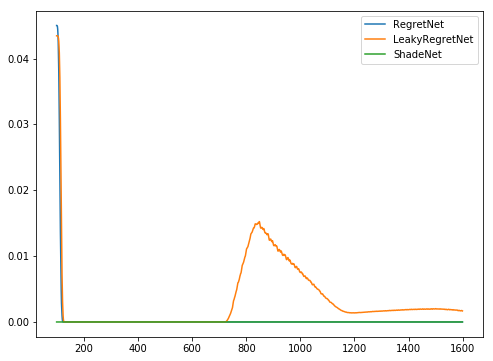

In [39]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(regret_net_report[['total_ir_violation']].rolling(100).mean(), label='RegretNet');
ax.plot(leaky_regret_net_report[['total_ir_violation']].rolling(100).mean(), label='LeakyRegretNet');
ax.plot(shade_net_report[['total_ir_violation']].rolling(100).mean(), label='ShadeNet');
ax.legend();

Next, let's review the DSIC violations of each network. In the figure below, we can see that ShadeNet has a large initial violation then quickly finds a region with low and decreasing violation. RegretNet quickly optimizes to epsilon violations, while LeakyRegretNet slowly attenuates.

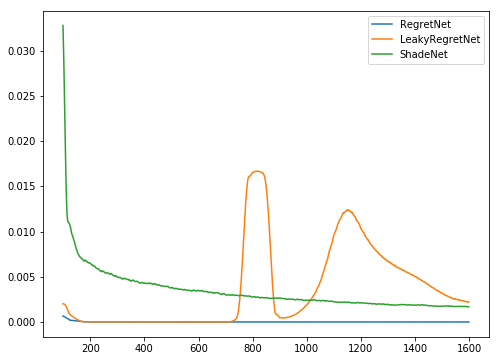

In [40]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(regret_net_report[['total_dsic_violation']].rolling(100).mean(), label='RegretNet');
ax.plot(leaky_regret_net_report[['total_dsic_violation']].rolling(100).mean(), label='LeakyRegretNet');
ax.plot(shade_net_report[['total_dsic_violation']].rolling(100).mean(), label='ShadeNet');
ax.legend();

Finally, let's review the revenue of each network.  ShadeNet and LeakyRegretNet converge to a near optimal mechanism, whereas RegretNet has close to 0 revenue.  This is likely to do with an exploding gradient during the initial few updates.

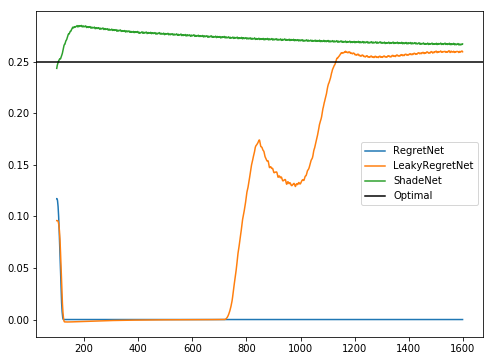

In [41]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(regret_net_report[['revenue']].rolling(100).mean(), label='RegretNet');
ax.plot(leaky_regret_net_report[['revenue']].rolling(100).mean(), label='LeakyRegretNet');
ax.plot(shade_net_report[['revenue']].rolling(100).mean(), label='ShadeNet');
ax.axhline(0.25, c='k', label='Optimal')
ax.legend();

### Two Bidders

For our warmup exercise, we consider only a single bidder.  From Myerson (81), we know that the optimal mechanism is a fixed price of 0.5.  Since the bidders values are drawn from uniformly from [0,1], we know that half of the draws will result in the bidder not winning the item, with the other half winning at a price of 0.5.  Therefore, the optimal expected revenue is 0.25.

In [42]:
bidders = 2

Again, the networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [43]:
sample_size = 1000
batch_size = 64

values_loader=data_utils.DataLoader(
    data_utils.TensorDataset(torch.rand(sample_size, bidders)),
    batch_size=batch_size)

Learning from our experience in the single-bidder experiment, we consider LeakyRegretNet and ShadeNet.

In [44]:
leaky_regret_net = create_regret_net(bidders, output_act_fn=F.leaky_relu).to(device)
shade_net = create_shade_net(bidders).to(device)

As above, we loop over the data for a number of epochs and record traces of the networks learning.

In [45]:
epochs = 100
leaky_regret_net_report = train(leaky_regret_net, values_loader, epochs=epochs)
shade_net_report = train(shade_net, values_loader, epochs=epochs)

LeakyRegretNet quickly conversions to minimal IR violations.

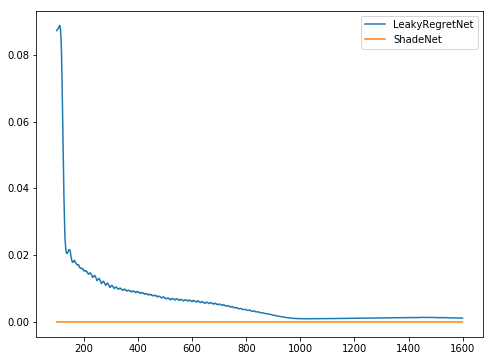

In [46]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(leaky_regret_net_report[['total_ir_violation']].rolling(100).mean(), label='LeakyRegretNet');
ax.plot(shade_net_report[['total_ir_violation']].rolling(100).mean(), label='ShadeNet');
ax.legend();

ShadeNet quickly settles into low DCIS violation, whereas LeakyRegretNet spikes and then quickly vanishes.

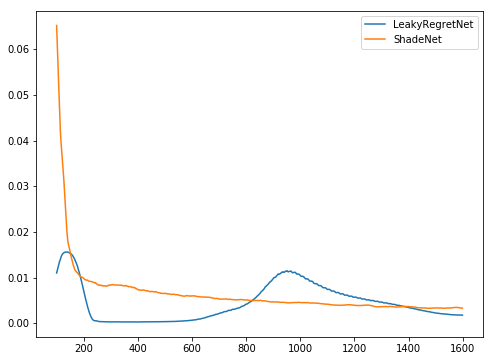

In [47]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(leaky_regret_net_report[['total_dsic_violation']].rolling(100).mean(), label='LeakyRegretNet');
ax.plot(shade_net_report[['total_dsic_violation']].rolling(100).mean(), label='ShadeNet');
ax.legend();

ShadeNet smoothly converges to optimal revenue, whereas LeakyRegretNet settles to a lower value.

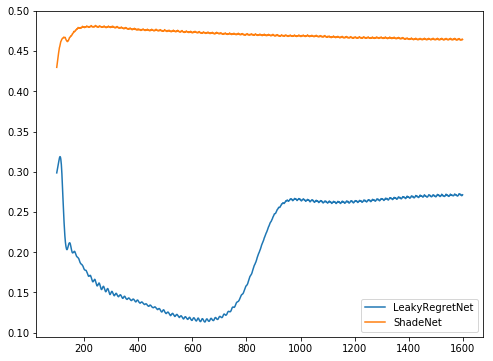

In [48]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(leaky_regret_net_report[['revenue']].rolling(100).mean(), label='LeakyRegretNet');
ax.plot(shade_net_report[['revenue']].rolling(100).mean(), label='ShadeNet');
ax.legend();